In [2]:
import os
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import SVHN
from sklearn.metrics import f1_score
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from torchvision.models import resnet18
import scipy
import tensorflow as tf
from PIL import Image as im

In [2]:
import wandb
wandb.login()
wandb.init(project="Assignement 1 Q1", name="baseline")
wandb.config = {"learning_rate": 0.001 , "epochs": 10, "batch_size": 64}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: satyam20330 (nemesis-19). Use `wandb login --relogin` to force relogin


In [3]:
g = torch.Generator()
g.manual_seed(42)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

transform_updt = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

cuda:0


In [4]:
# data = SVHN(root='data', split='train', download=True, transform=transform_updt)
data = SVHN(root='data', split='train', download=True)
X = data.data
y = data.labels

# save the images as jpg files and save the labels as text files

mat = scipy.io.loadmat('data/train_32x32.mat')
arr =  np.array(mat["X"])

for i in range(5000):
	img =  Image.fromarray(arr[:,:,:,i], 'RGB')
	img.save("data/images/svhn"+str(i)+".jpg")
	print("saving: " + str(i))

dataset_size = len(data)
train_size = int(0.7 * dataset_size)
test_size = int(0.1 * dataset_size)
val_size = int(0.2 * dataset_size)

train_data = X[:train_size]
train_labels = y[:train_size]
test_data = X[train_size:train_size + test_size]
test_labels = y[train_size:train_size + test_size]
val_data = X[train_size + test_size:]
val_labels = y[train_size + test_size:]

train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)
val_data = val_data.astype(np.float32)

class custom_data_loader(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = custom_data_loader(train_data, train_labels)
test_dataset = custom_data_loader(test_data, test_labels)
val_dataset = custom_data_loader(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

Using downloaded and verified file: data\train_32x32.mat
saving: 0
saving: 1
saving: 2
saving: 3
saving: 4
saving: 5
saving: 6
saving: 7
saving: 8
saving: 9
saving: 10
saving: 11
saving: 12
saving: 13
saving: 14
saving: 15
saving: 16
saving: 17
saving: 18
saving: 19
saving: 20
saving: 21
saving: 22
saving: 23
saving: 24
saving: 25
saving: 26
saving: 27
saving: 28
saving: 29
saving: 30
saving: 31
saving: 32
saving: 33
saving: 34
saving: 35
saving: 36
saving: 37
saving: 38
saving: 39
saving: 40
saving: 41
saving: 42
saving: 43
saving: 44
saving: 45
saving: 46
saving: 47
saving: 48
saving: 49
saving: 50
saving: 51
saving: 52
saving: 53
saving: 54
saving: 55
saving: 56
saving: 57
saving: 58
saving: 59
saving: 60
saving: 61
saving: 62
saving: 63
saving: 64
saving: 65
saving: 66
saving: 67
saving: 68
saving: 69
saving: 70
saving: 71
saving: 72
saving: 73
saving: 74
saving: 75
saving: 76
saving: 77
saving: 78
saving: 79
saving: 80
saving: 81
saving: 82
saving: 83
saving: 84
saving: 85
saving:

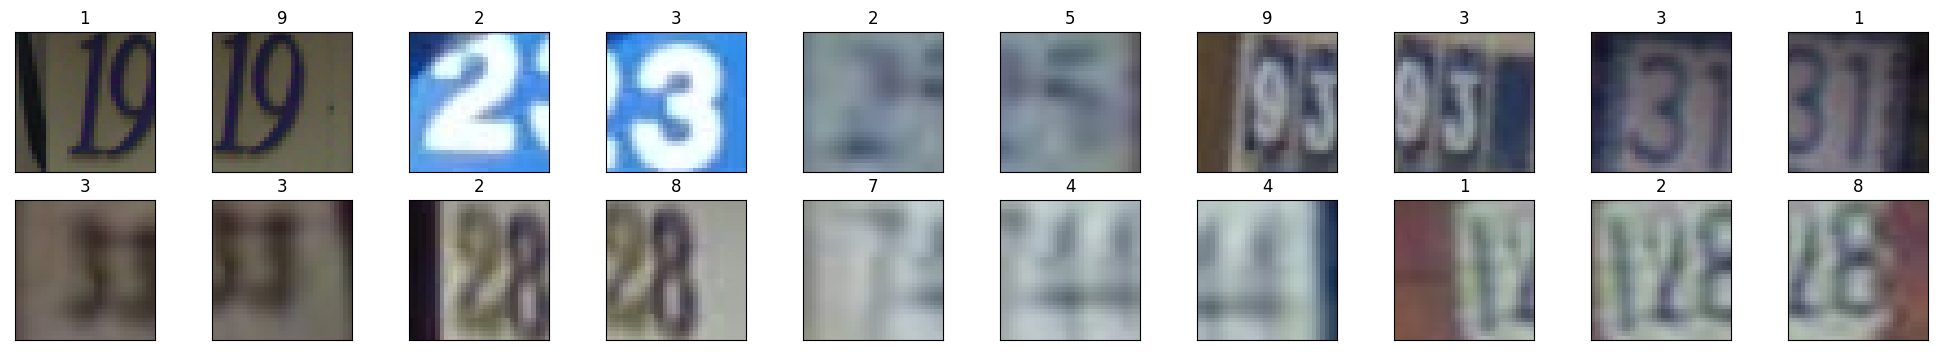

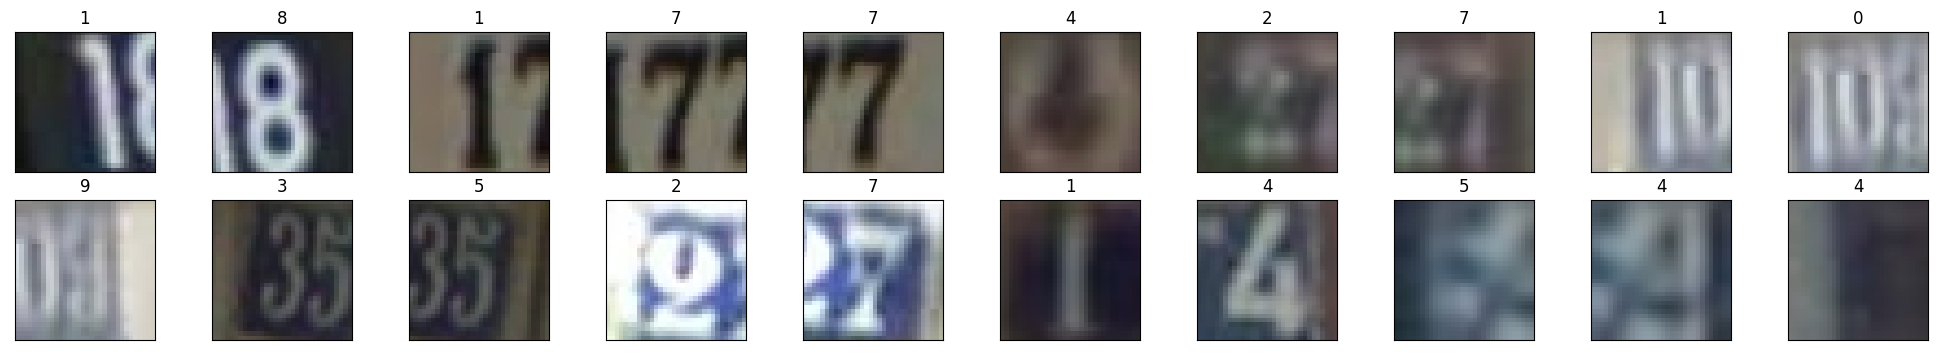

Training Data
0: 3481.0
1: 9694.0
2: 7421.0
3: 5988.0
4: 5232.0
5: 4747.0
6: 4022.0
7: 3939.0
8: 3497.0
9: 3258.0


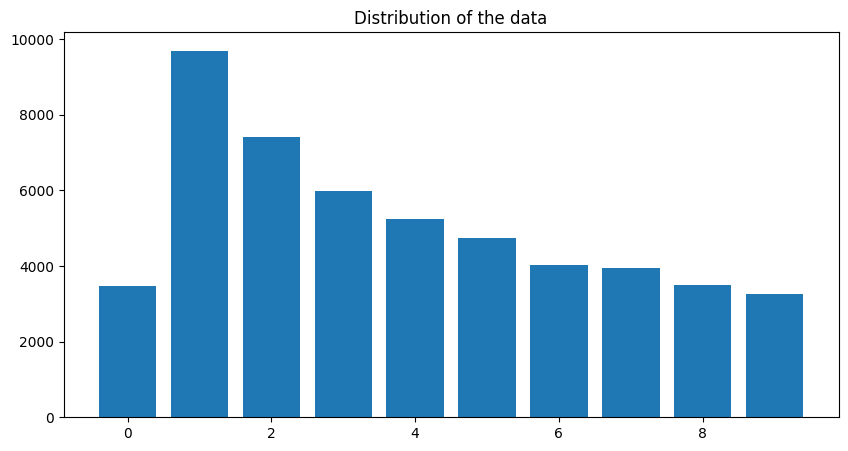

Validation Data
0: 991.0
1: 2748.0
2: 2118.0
3: 1727.0
4: 1473.0
5: 1419.0
6: 1160.0
7: 1098.0
8: 1024.0
9: 895.0


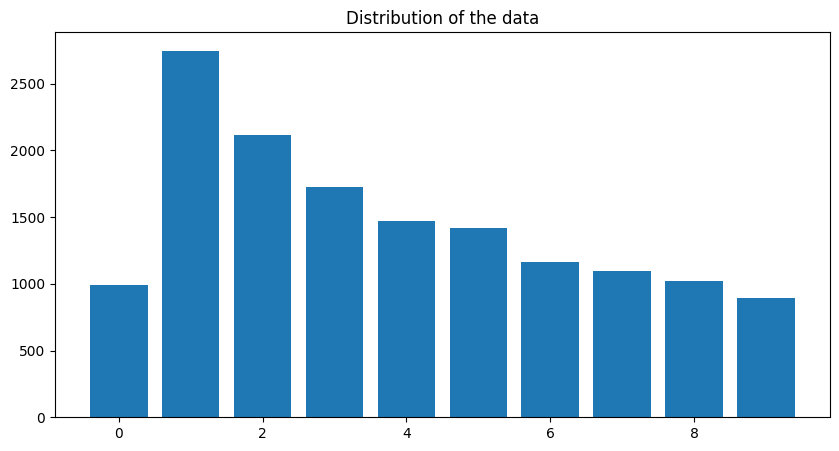

In [5]:
def plot_images(images, labels):
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        i1 = images[idx]
        i1 = np.transpose(i1, (1, 2, 0))
        i1 = i1.astype(np.uint8)
        img = im.fromarray(i1)
        plt.imshow(img)
        ax.set_title(str(labels[idx]))
    
    plt.show()

plot_images(train_data, train_labels)

plot_images(val_data, val_labels)

def plot_distribution(labels):
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(10), labels)
    plt.title("Distribution of the data")
    plt.show()

label_count = np.zeros(10)
print("Training Data")
for i in range(10): 
  label_count[i] = np.count_nonzero(train_labels == i)
  print(str(i) + ": " + str(label_count[i]))

plot_distribution(label_count)

label_count = np.zeros(10)
print("Validation Data")
for i in range(10): 
  label_count[i] = np.count_nonzero(val_labels == i)
  print(str(i) + ": " + str(label_count[i]))

plot_distribution(label_count)

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.mpool1 = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.mpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features = 4096, out_features=128)
        self.fc2 = nn.Linear(in_features = 128, out_features=10)

    def get_featues(self, x):
        out = self.cnn1(x)
        out = self.relu(out)
        out = self.mpool1(out)

        out = self.cnn2(out)
        out = self.relu(out)
        out = self.mpool2(out)

        out = out.view(-1, 4096)
        out = self.fc1(out)
        out = self.relu(out)
        return out

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu(out)
        out = self.mpool1(out)

        out = self.cnn2(out)
        out = self.relu(out)
        out = self.mpool2(out)

        out = out.view(-1, 4096)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = ConvNet().cuda()

criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [7]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

wandb.watch(model, log="all")

for epoch in range(10):
    model.train()
    train_loss_epoch = []
    train_acc_epoch = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterian(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        train_acc_epoch.append((predicted == labels).sum().item() / len(labels))
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    model.eval()
    val_loss_epoch = []
    val_acc_epoch = []
    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterian(outputs, labels)
        val_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        val_acc_epoch.append((predicted == labels).sum().item() / len(labels))
    val_loss.append(np.mean(val_loss_epoch))
    val_acc.append(np.mean(val_acc_epoch))

    wandb.log({"Train Loss": train_loss[-1], "Train Acc": train_acc[-1], "Val Loss": val_loss[-1], "Val Acc": val_acc[-1]})
    print("Epoch: {}, Train Loss: {}, Train Acc: {}, Val Loss: {}, Val Acc: {}".format(epoch, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1]))

Epoch: 0, Train Loss: 1.550333895142239, Train Acc: 0.5235777743142145, Val Loss: 0.9446740330046441, Val Acc: 0.7241581806142172
Epoch: 1, Train Loss: 0.7390666891660477, Train Acc: 0.7883845074812967, Val Loss: 0.7159149761283241, Val Acc: 0.7962206492948671
Epoch: 2, Train Loss: 0.6051189857453777, Train Acc: 0.8303602971737324, Val Loss: 0.6162093104753953, Val Acc: 0.829589179611998
Epoch: 3, Train Loss: 0.5425630580457369, Train Acc: 0.848907678719867, Val Loss: 0.5609364508281108, Val Acc: 0.8488270903429022
Epoch: 4, Train Loss: 0.5009104375009822, Train Acc: 0.8601491064006651, Val Loss: 0.5399049518540436, Val Acc: 0.8507543489154556
Epoch: 5, Train Loss: 0.46797895189978533, Train Acc: 0.8691149729842061, Val Loss: 0.538765966957313, Val Acc: 0.8575193285131362
Epoch: 6, Train Loss: 0.4392383637979738, Train Acc: 0.8765923732335827, Val Loss: 0.523400527941608, Val Acc: 0.8593996080607059
Epoch: 7, Train Loss: 0.41147000088990476, Train Acc: 0.8837866271820449, Val Loss: 0.5

Test Loss: 0.48665446988914324, Test Acc: 0.8637743628185908
F1 Score: 0.8541010985921759


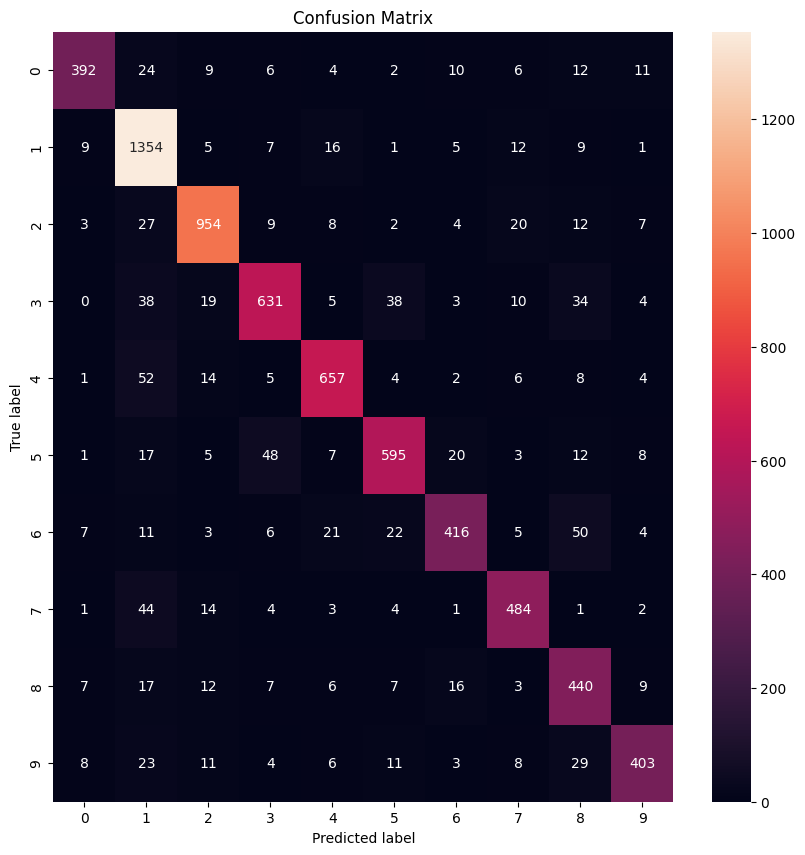

In [8]:
# testing the model
model.eval()
test_loss = []
test_acc = []
y_pred = []
y_true = []
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterian(outputs, labels)
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    test_acc.append((predicted == labels).sum().item() / len(labels))

wandb.log({"Test Loss": np.mean(test_loss), "Test Acc": np.mean(test_acc), "F1 Score": f1_score(y_true, y_pred, average='macro')})
print("Test Loss: {}, Test Acc: {}".format(np.mean(test_loss), np.mean(test_acc)))
print("F1 Score: {}".format(f1_score(y_true, y_pred, average='macro')))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=y_pred)})

c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


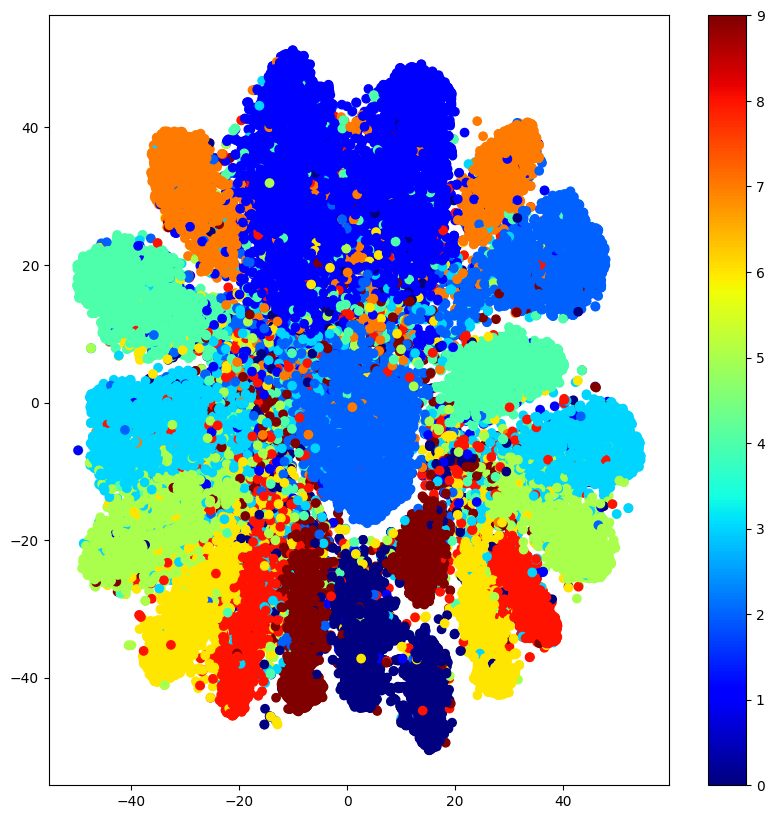

c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


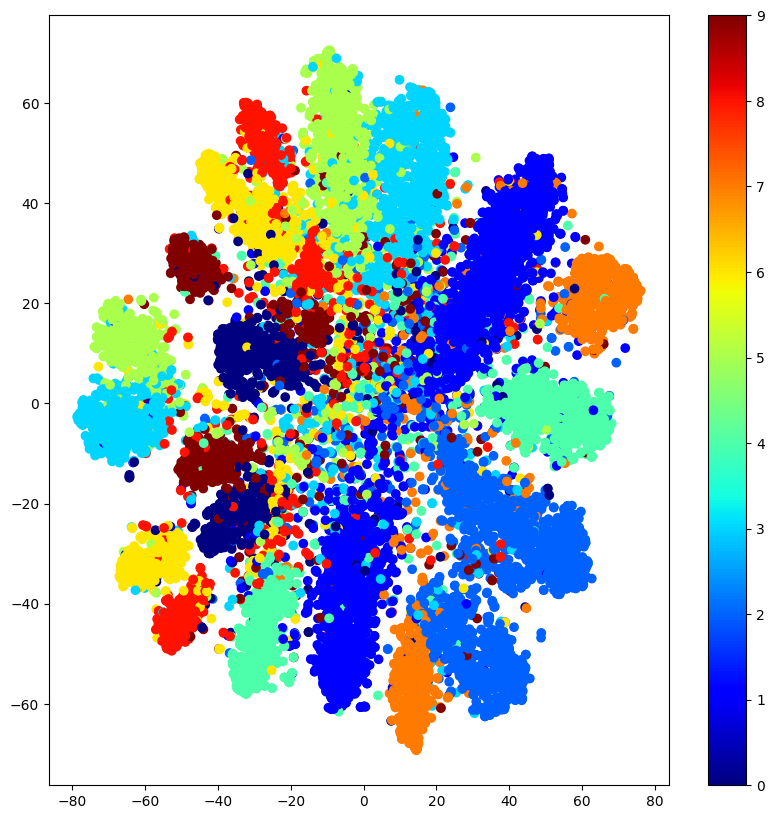

c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


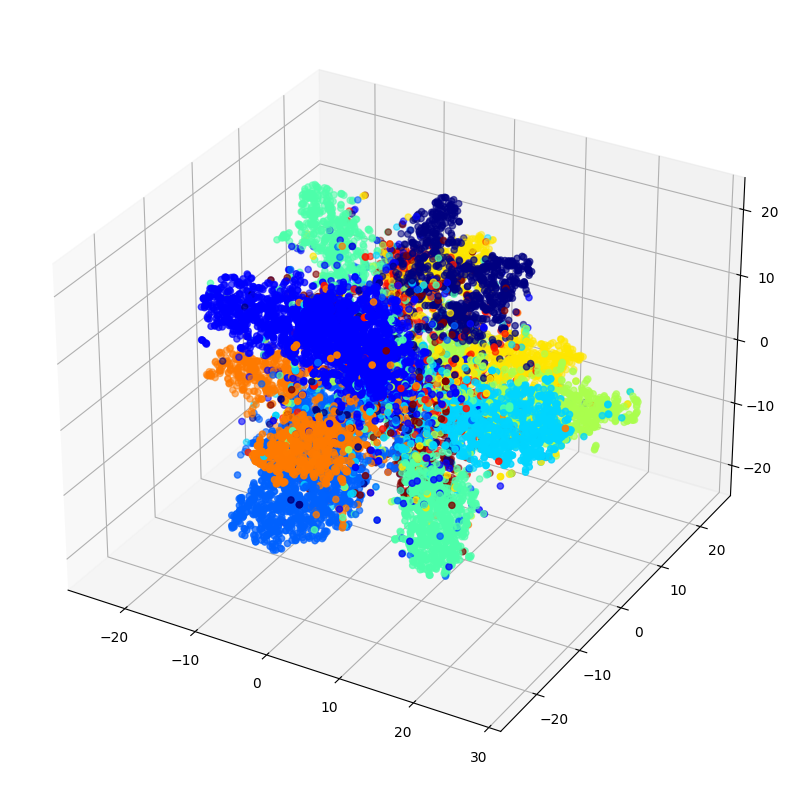

In [9]:
from sklearn.manifold import TSNE

model.eval()
features = []
labels = []
for i, (images, label) in enumerate(train_loader):
    images = images.to(device)
    label = label.to(device)
    outputs = model.get_featues(images)
    features.extend(outputs.cpu().detach().numpy())
    labels.extend(label.cpu().detach().numpy())

features = np.array(features)
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.show()

model.eval()
features = []
labels = []
for i, (images, label) in enumerate(val_loader):
    images = images.to(device)
    label = label.to(device)
    outputs = model.get_featues(images)
    features.extend(outputs.cpu().detach().numpy())
    labels.extend(label.cpu().detach().numpy())

features = np.array(features)
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.show()

tsne = TSNE(n_components=3, random_state=42)
features_3d = tsne.fit_transform(features)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], c=labels, cmap='jet')
plt.show()

Predicted: 3, True: 5


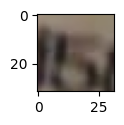

Predicted: 2, True: 8


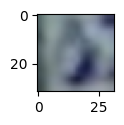

Predicted: 1, True: 4


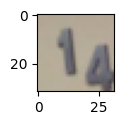

In [10]:
model.eval()
y_pred = []
y_true = []
imgs_pred = []
imgs = []
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    imgs.extend(images.cpu().numpy())
    imgs_pred.extend(outputs.cpu().detach().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
imgs = np.array(imgs)
imgs_pred = np.array(imgs_pred)

count = 0
for i in range(len(y_pred)):
    if y_pred[i] != y_true[i]:
        print("Predicted: {}, True: {}".format(y_pred[i], y_true[i]))
        ts1 = imgs[i]
        ts1 = np.transpose(ts1, (1, 2, 0))
        ts1 = ts1.astype(np.uint8)
        img = im.fromarray(ts1)
        plt.figure(figsize=(1, 1))
        plt.imshow(img)
        plt.show()
        count += 1
    if count == 3:
        break

In [11]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)
model = model.to(device)

criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

C:\Users\Satyam Arora\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Satyam Arora\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(10):
    model.train()
    train_loss_epoch = []
    train_acc_epoch = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterian(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        train_acc_epoch.append((predicted == labels).sum().item() / len(labels))
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    model.eval()
    val_loss_epoch = []
    val_acc_epoch = []
    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterian(outputs, labels)
        val_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        val_acc_epoch.append((predicted == labels).sum().item() / len(labels))
    val_loss.append(np.mean(val_loss_epoch))
    val_acc.append(np.mean(val_acc_epoch))

    wandb.log({"Train Loss": train_loss[-1], "Train Acc": train_acc[-1], "Val Loss": val_loss[-1], "Val Acc": val_acc[-1]})
    print("Epoch: {}, Train Loss: {}, Train Acc: {}, Val Loss: {}, Val Acc: {}".format(epoch, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1]))

Epoch: 0, Train Loss: 0.8757624178381632, Train Acc: 0.7055694098088113, Val Loss: 0.41293793044756594, Val Acc: 0.8696376798625528
Epoch: 1, Train Loss: 0.36181906099777267, Train Acc: 0.8859634767248546, Val Loss: 0.329490211072447, Val Acc: 0.8972982586441405
Epoch: 2, Train Loss: 0.26372874057166595, Train Acc: 0.9193812344139651, Val Loss: 0.3066169492021919, Val Acc: 0.9070352208461594
Epoch: 3, Train Loss: 0.20334335463934408, Train Acc: 0.9377870428096426, Val Loss: 0.3000265855878982, Val Acc: 0.9143494076168659
Epoch: 4, Train Loss: 0.1588731340458965, Train Acc: 0.9506117518703242, Val Loss: 0.3112594523674536, Val Acc: 0.9136022174099793
Epoch: 5, Train Loss: 0.12831298673660158, Train Acc: 0.959256805901912, Val Loss: 0.30122074605205695, Val Acc: 0.9172251950748086
Epoch: 6, Train Loss: 0.10657667689561899, Train Acc: 0.9662211658354114, Val Loss: 0.32544628592557784, Val Acc: 0.9140015391223424
Epoch: 7, Train Loss: 0.09112943214668598, Train Acc: 0.9709463320864506, Val

Test Loss: 0.37225166338941323, Test Acc: 0.9130950149925038
F1 Score: 0.9068627002094412


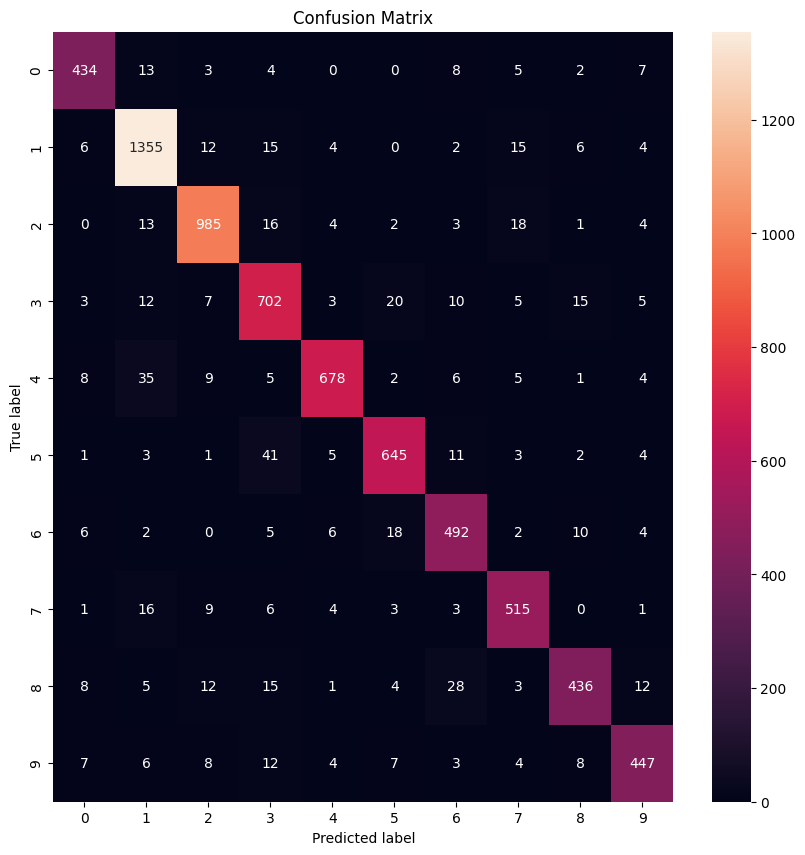

In [13]:
model.eval()
test_loss = []
test_acc = []
y_pred = []
y_true = []
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterian(outputs, labels)
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    test_acc.append((predicted == labels).sum().item() / len(labels))

wandb.log({"Test Loss": np.mean(test_loss), "Test Acc": np.mean(test_acc), "F1 Score": f1_score(y_true, y_pred, average='macro')})
print("Test Loss: {}, Test Acc: {}".format(np.mean(test_loss), np.mean(test_acc)))
print("F1 Score: {}".format(f1_score(y_true, y_pred, average='macro')))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=y_pred)})

Predicted: 5, True: 9


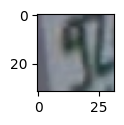

Predicted: 7, True: 2


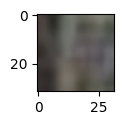

Predicted: 7, True: 1


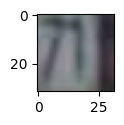

In [14]:
model.eval()
y_pred = []
y_true = []
imgs_pred = []
imgs = []
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    imgs.extend(images.cpu().numpy())
    imgs_pred.extend(outputs.cpu().detach().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
imgs = np.array(imgs)
imgs_pred = np.array(imgs_pred)

count = 0
for i in range(len(y_pred)):
    if y_pred[i] != y_true[i]:
        print("Predicted: {}, True: {}".format(y_pred[i], y_true[i]))
        ts1 = imgs[i]
        ts1 = np.transpose(ts1, (1, 2, 0))
        ts1 = ts1.astype(np.uint8)
        img = im.fromarray(ts1)
        plt.figure(figsize=(1, 1))
        plt.imshow(img)
        plt.show()
        count += 1
    if count == 3:
        break

C:\Users\Satyam Arora\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Satyam Arora\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' i

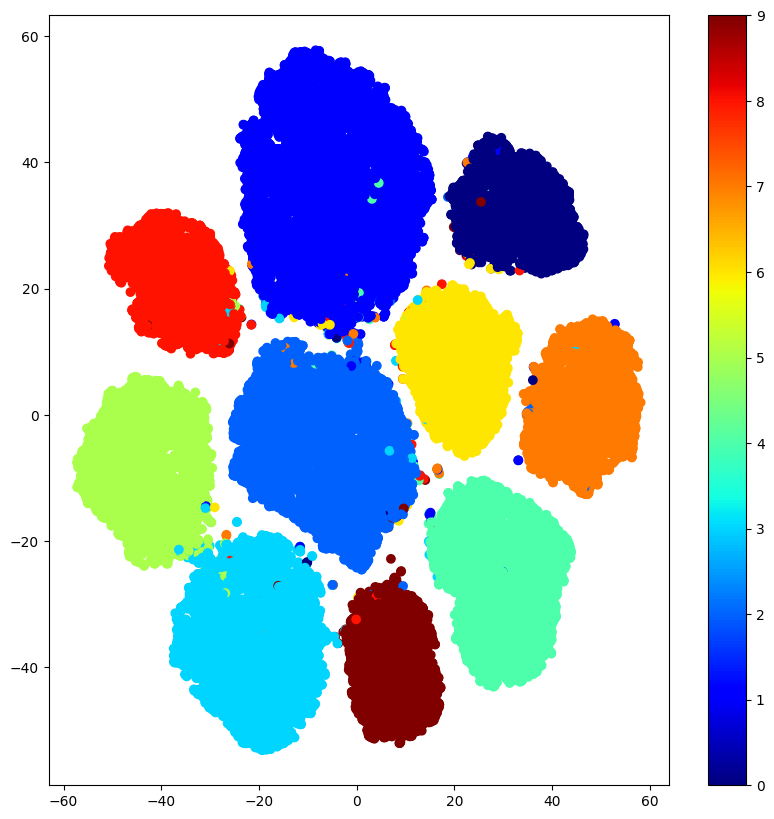

In [15]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)
features = resnet18.fc.in_features
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
resnet18 = resnet18.to(device)
resnet18.eval()

y_pred = []
y_true = []
imgs_pred = []
imgs = []
for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    imgs.extend(images.cpu().numpy())
    imgs_pred.extend(outputs.cpu().detach().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
imgs = np.array(imgs)
imgs_pred = np.array(imgs_pred)

tsne = TSNE(n_components=2, random_state=42)
imgs_pred_2d = tsne.fit_transform(imgs_pred)

plt.figure(figsize=(10, 10))
plt.scatter(imgs_pred_2d[:, 0], imgs_pred_2d[:, 1], c=y_true, cmap='jet')
plt.colorbar()
plt.show()

c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


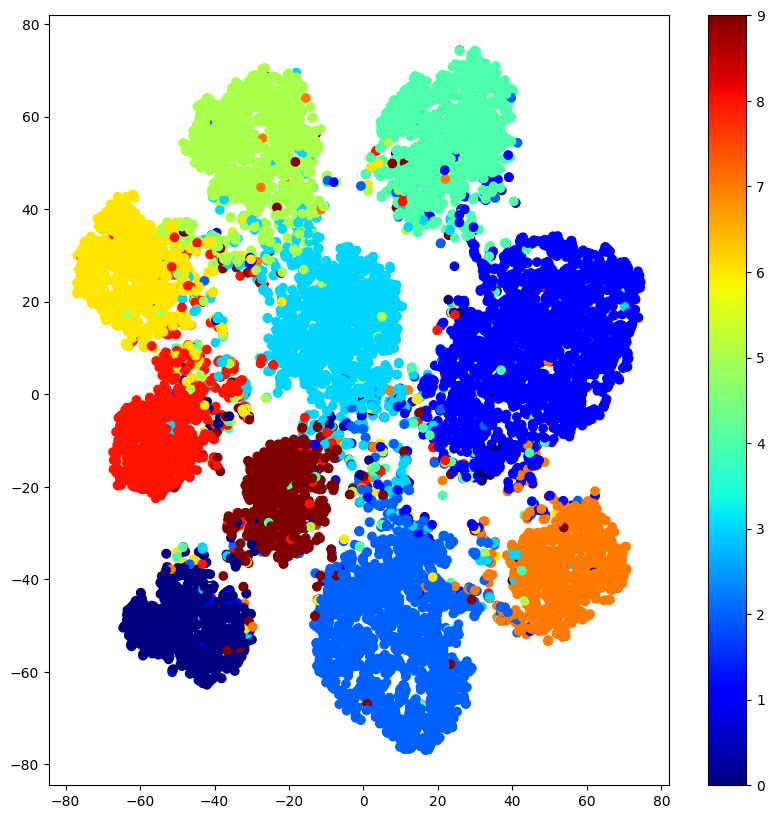

In [16]:
resnet18.eval()

y_pred = []
y_true = []
imgs_pred = []
imgs = []
for i, (images, labels) in enumerate(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    imgs.extend(images.cpu().numpy())
    imgs_pred.extend(outputs.cpu().detach().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
imgs = np.array(imgs)
imgs_pred = np.array(imgs_pred)

tsne = TSNE(n_components=2, random_state=42)
imgs_pred_2d = tsne.fit_transform(imgs_pred)

plt.figure(figsize=(10, 10))
plt.scatter(imgs_pred_2d[:, 0], imgs_pred_2d[:, 1], c=y_true, cmap='jet')
plt.colorbar()
plt.show()

c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


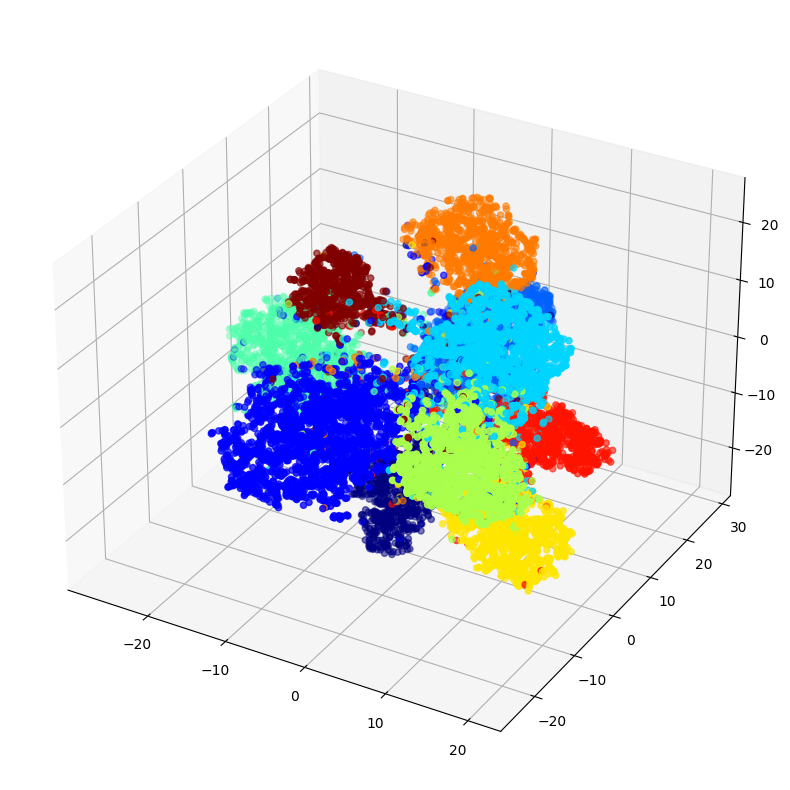

In [17]:
resnet18.eval()

y_pred = []
y_true = []
imgs_pred = []
imgs = []
for i, (images, labels) in enumerate(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    imgs.extend(images.cpu().numpy())
    imgs_pred.extend(outputs.cpu().detach().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
imgs = np.array(imgs)
imgs_pred = np.array(imgs_pred)

tsne = TSNE(n_components=3, random_state=42)
features_3d = tsne.fit_transform(imgs_pred)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], c=y_true, cmap='jet')
plt.show()

In [18]:
transform_new = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

new_data = SVHN(root='data', split='train', download=True, transform=transform_new)

new_train_data = new_data.data[:int(0.7 * len(new_data))]
new_train_labels = new_data.labels[:int(0.7 * len(new_data))]

new_train_data = new_train_data.astype(np.float32)

train_data_n = np.concatenate((train_data, new_train_data))

train_labels_n = np.concatenate((train_labels, new_train_labels))

train_dataset_n = custom_data_loader(train_data_n, train_labels_n)

train_loader_n = DataLoader(train_dataset_n, batch_size=64, shuffle=True)

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)
model = model.to(device)

criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Using downloaded and verified file: data\train_32x32.mat
51279 51279


C:\Users\Satyam Arora\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Satyam Arora\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(10):
    model.train()
    train_loss_epoch = []
    train_acc_epoch = []
    for i, (images, labels) in enumerate(train_loader_n):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterian(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        train_acc_epoch.append((predicted == labels).sum().item() / len(labels))
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    model.eval()
    val_loss_epoch = []
    val_acc_epoch = []
    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterian(outputs, labels)
        val_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        val_acc_epoch.append((predicted == labels).sum().item() / len(labels))
    val_loss.append(np.mean(val_loss_epoch))
    val_acc.append(np.mean(val_acc_epoch))

    wandb.log({"Train Loss": train_loss[-1], "Train Acc": train_acc[-1], "Val Loss": val_loss[-1], "Val Acc": val_acc[-1]})
    print("Epoch: {}, Train Loss: {}, Train Acc: {}, Val Loss: {}, Val Acc: {}".format(epoch, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1]))

Epoch: 0, Train Loss: 0.5959471290372196, Train Acc: 0.8054988043252236, Val Loss: 0.3387077237971485, Val Acc: 0.8982501431741714
Epoch: 1, Train Loss: 0.22736847223580367, Train Acc: 0.9300322312331046, Val Loss: 0.30515672998527255, Val Acc: 0.9116850257713508
Epoch: 2, Train Loss: 0.14477027559516972, Train Acc: 0.9550595238095239, Val Loss: 0.3138904010299512, Val Acc: 0.9159869622020187
Epoch: 3, Train Loss: 0.09498133385729414, Train Acc: 0.9702900810979413, Val Loss: 0.3462393427975313, Val Acc: 0.9127152086763548
Epoch: 4, Train Loss: 0.06741390722360478, Train Acc: 0.9779794395924308, Val Loss: 0.3579726773802207, Val Acc: 0.9129914900851885
Epoch: 5, Train Loss: 0.05193062980295608, Train Acc: 0.9829518870867124, Val Loss: 0.3811348302119033, Val Acc: 0.9131760505404826
Epoch: 6, Train Loss: 0.040187377665736275, Train Acc: 0.9871029579954252, Val Loss: 0.38131065469837083, Val Acc: 0.9166793435464243
Epoch: 7, Train Loss: 0.035779183931686206, Train Acc: 0.9882057080474111,

Test Loss: 0.41288747563958167, Test Acc: 0.9199681409295353
F1 Score: 0.9147212275345691


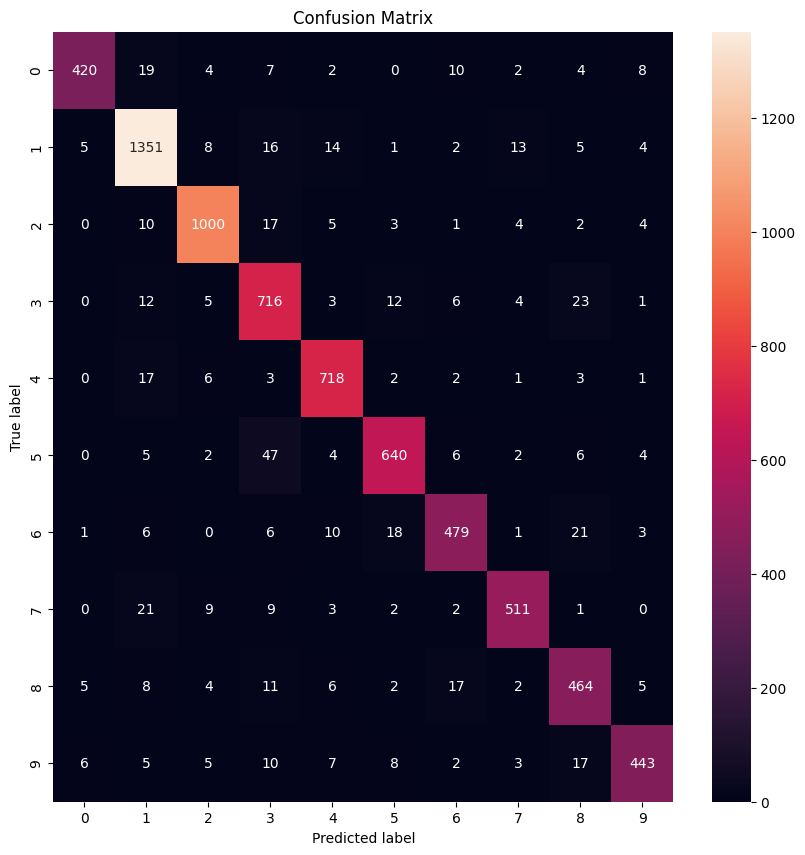

In [20]:
model.eval()
test_loss = []
test_acc = []
y_pred = []
y_true = []
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterian(outputs, labels)
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    test_acc.append((predicted == labels).sum().item() / len(labels))

wandb.log({"Test Loss": np.mean(test_loss), "Test Acc": np.mean(test_acc), "F1 Score": f1_score(y_true, y_pred, average='macro')})
print("Test Loss: {}, Test Acc: {}".format(np.mean(test_loss), np.mean(test_acc)))
print("F1 Score: {}".format(f1_score(y_true, y_pred, average='macro')))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=y_pred)})

Predicted: 9, True: 6


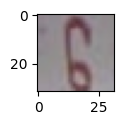

Predicted: 7, True: 4


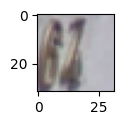

Predicted: 3, True: 5


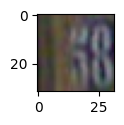

In [21]:
model.eval()
y_pred = []
y_true = []
imgs_pred = []
imgs = []
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    imgs.extend(images.cpu().numpy())
    imgs_pred.extend(outputs.cpu().detach().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
imgs = np.array(imgs)
imgs_pred = np.array(imgs_pred)

count = 0
for i in range(len(y_pred)):
    if y_pred[i] != y_true[i]:
        print("Predicted: {}, True: {}".format(y_pred[i], y_true[i]))
        ts1 = imgs[i]
        ts1 = np.transpose(ts1, (1, 2, 0))
        ts1 = ts1.astype(np.uint8)
        img = im.fromarray(ts1)
        plt.figure(figsize=(1, 1))
        plt.imshow(img)
        plt.show()
        count += 1
    if count == 3:
        break

In [22]:
wandb.finish()

F1 Score,▁▇█
Test Acc,▁▇█
Test Loss,█▁▃
Train Acc,▁▅▆▆▆▆▆▆▇▇▄▆▇▇▇█████▅▇▇███████
Train Loss,█▄▄▃▃▃▃▃▃▃▅▃▂▂▂▁▁▁▁▁▄▂▂▁▁▁▁▁▁▁
Val Acc,▁▄▅▅▅▆▆▆▆▆▆▇▇████▇██▇█████████
Val Loss,█▆▄▄▄▄▃▃▃▃▂▁▁▁▁▁▁▂▂▂▁▁▁▂▂▂▂▂▂▂
F1 Score,0.91472
Test Acc,0.91997
Test Loss,0.41289
Train Acc,0.99061
